In [1]:
!pip install iapws

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 111 kB 5.2 MB/s 
  Created wheel for iapws: filename=iapws-1.5.3-py3-none-any.whl size=114281 sha256=b011e5952c24f89a89f9c9acecdce269b9940bdaa085211cf52d3f4c22337bb5
  Stored in directory: /root/.cache/pip/wheels/31/41/85/a38aabccfd7dea1498653150e52ad2b2d7e3a8199263b8e09a
Successfully built iapws


In [2]:
import iapws # steam tables
import openpyxl
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ipywidgets import interactive, Layout, FloatSlider

In [3]:


def timedelta_seconds(dataframe_col, test_start):
    '''
    Make a float in seconds since the start of the test

    args:   dataframe_col: dataframe column containing datetime objects
            test_start: test start time formatted '2020-12-11 09:00:00'

    returns: float in seconds since the start of the test
    '''
    test_start_datetime = pd.to_datetime(test_start)
    list = []
    for datetime in dataframe_col:
        time_delta = datetime - test_start_datetime
        seconds = time_delta.total_seconds()
        list.append(seconds)
    return list



def read_flowrate(filename):
    ''' 
    Read PTS-2-injection-rate.xlsx in as a pandas dataframe and munge for analysis

    args: filename is r'PTS-2-injection-rate.xlsx'

    returns: pandas dataframe with local NZ datetime and flowrate in t/hr
    '''
    df = pd.read_excel(filename, header=1) 
    df.columns = ['raw_datetime','flow_Lpm']

    list = []
    for date in df['raw_datetime']:
        newdate = datetime.fromisoformat(date)
        list.append(newdate)
    df['ISO_datetime'] = list 

    list = []
    for date in df.ISO_datetime:
        newdate = pd.to_datetime(datetime.strftime(date,'%Y-%m-%d %H:%M:%S'))
        list.append(newdate)
    df['datetime'] = list

    df['flow_tph'] = df.flow_Lpm * 0.060

    df['timedelta_sec'] = timedelta_seconds(df.datetime, '2020-12-11 09:26:44.448')

    df.drop(columns = ['raw_datetime', 'flow_Lpm', 'ISO_datetime'], inplace = True)

    return df



def read_pts(filename):
    '''
    Read PTS-2.xlsx in as a Pandas dataframe and munge for analysis

    args: filename is r'PTS-2.xlsx'

    returns: Pandas dataframe with datetime (local) and key coloumns of PTS data with the correct dtype
    '''
    df = pd.read_excel(filename)

    dict = {
        'DEPTH':'depth_m',
        'SPEED': 'speed_mps',
        'Cable Weight': 'cweight_kg',
        'WHP': 'whp_barg',
        'Temperature': 'temp_degC',
        'Pressure': 'pressure_bara',
        'Frequency': 'frequency_hz'
    }
    df.rename(columns=dict, inplace=True)

    df.drop(0, inplace=True)
    df.reset_index(drop=True, inplace=True)

    list = []
    for date in df.Timestamp:
        newdate = openpyxl.utils.datetime.from_excel(date)
        list.append(newdate)
    df['datetime'] = list

    df.drop(columns = ['Date', 'Time', 'Timestamp','Reed 0',
       'Reed 1', 'Reed 2', 'Reed 3', 'Battery Voltage', 
       'PRT Ref Voltage','SGS Voltage', 'Internal Temp 1', 
       'Internal Temp 2', 'Internal Temp 3','Cal Temp', 
       'Error Code 1', 'Error Code 2', 'Error Code 3',
       'Records Saved', 'Bad Pages',], inplace = True)
    
    df[
        ['depth_m', 'speed_mps','cweight_kg','whp_barg','temp_degC','pressure_bara','frequency_hz']
    ] = df[
        ['depth_m','speed_mps','cweight_kg','whp_barg','temp_degC','pressure_bara','frequency_hz']
        ].apply(pd.to_numeric)
    
    df['timedelta_sec'] = timedelta_seconds(df.datetime, '2020-12-11 09:26:44.448')

    return df



def append_flowrate_to_pts(flowrate_df, pts_df):
    '''
    Add surface flowrate to pts data

    Note that the flowrate data is recorded at a courser time resolution than the pts data
    The function makes a linear interpolation to fill the data gaps
    Refer to bonus-combine-data.ipynb to review this method and adapt it for your own data

    Args:   flowrate and pts dataframes generated by the read_flowrate and read_pts functions

    Returns: pts dataframe with flowrate tph added
    
    '''
    flowrate_df = flowrate_df.set_index('timedelta_sec')
    pts_df = pts_df.set_index('timedelta_sec')
    combined_df = pts_df.join(flowrate_df, how = 'outer',  lsuffix = '_pts', rsuffix = '_fr')
    combined_df.drop(columns = ['datetime_fr'], inplace = True)
    combined_df.columns = ['depth_m', 'speed_mps', 'cweight_kg', 'whp_barg', 'temp_degC',
       'pressure_bara', 'frequency_hz', 'datetime', 'flow_tph']
    combined_df['interpolated_flow_tph'] = combined_df['flow_tph'].interpolate(method='linear')
    trimmed_df = combined_df[combined_df['depth_m'].notna()]
    trimmed_df.reset_index(inplace=True)
    return trimmed_df



def find_index(value, df, colname):
    '''
    Find the dataframe index for the exact matching value or nearest two values

    args:   value: (float or int) the search term
            df: (obj) the name of the dataframe that is searched
            colname: (str) the name of the coloum this is searched

    returns:  dataframe index(s) for the matching value or the two adjacent values
              rows can be called from a df using df.iloc[[index_number,index_number]]
    '''
    exactmatch = df[df[colname] == value]
    if not exactmatch.empty:
        return exactmatch.index
    else:
        lowerneighbour_index = df[df[colname] < value][colname].idxmax()
        upperneighbour_index = df[df[colname] > value][colname].idxmin()
        return [lowerneighbour_index, upperneighbour_index] 

    

def overview_fig(pts_df,flowrate_df,title=''):
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1,figsize=(10,15),sharex=True)
    ax1.set_title(title,y=1.1,fontsize=15)

    ax1.plot(flowrate_df.datetime, flowrate_df.flow_tph, label='Surface pump flowrate', 
        c='k', linewidth=0.8, marker='.')
    ax1.set_ylabel('Surface flowrate [t/hr]')
    ax1.set_ylim(0,150)
    
    ax2.plot(pts_df.datetime, pts_df.depth_m, label='PTS tool depth', 
        c='k', linewidth=0.8)
    ax2.set_ylabel('PTS tool depth [m]')
    ax2.set_ylim(1000,0)
    
    ax3.plot(pts_df.datetime, pts_df.pressure_bara, label='PTS pressure', 
        c='tab:blue', linewidth=0.8)
    ax3.set_ylabel('PTS pressure [bara]')
    
    ax4.plot(pts_df.datetime, pts_df.temp_degC, label='PTS temperature', 
        c='tab:red', linewidth=0.8)
    ax4.set_ylabel('PTS temperature')
    
    ax5.plot(pts_df.datetime, pts_df.frequency_hz, label='PTS impeller frequency', 
        c='tab:green', linewidth=0.8)
    ax5.set_ylim(-30,30)
    ax5.set_ylabel('PTS impeller frequency [hz]')
    # 1 hz = 60 rpm

    ax6.plot(pts_df.datetime, pts_df.speed_mps, label='PTS tool speed', 
        c='tab:orange', linewidth=0.8)
    ax6.set_ylim(-2,2)
    ax6.set_ylabel('PTS tool speed [mps]')
    
    ax6.set_xlabel('Time [hh:mm]')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
        ax.grid()
    
    return plt

In [4]:


flowrate = read_flowrate(r'Data-FlowRate.xlsx')

In [5]:
pts = read_pts(r'Data-PTS.xlsx')

In [6]:
print(pts.shape)
pts.head(2)

(101293, 9)


,depth_m,speed_mps,cweight_kg,whp_barg,temp_degC,pressure_bara,frequency_hz,datetime,timedelta_sec
0,-6.32025,NaN,24.957275,-0.607066,19.702093,0.498792,40.648876,2020-12-11 09:26:44.448,0.000
1,-6.32025,NaN,25.211151,-0.606777,19.689250,0.485864,41.483227,2020-12-11 09:26:45.312,0.864


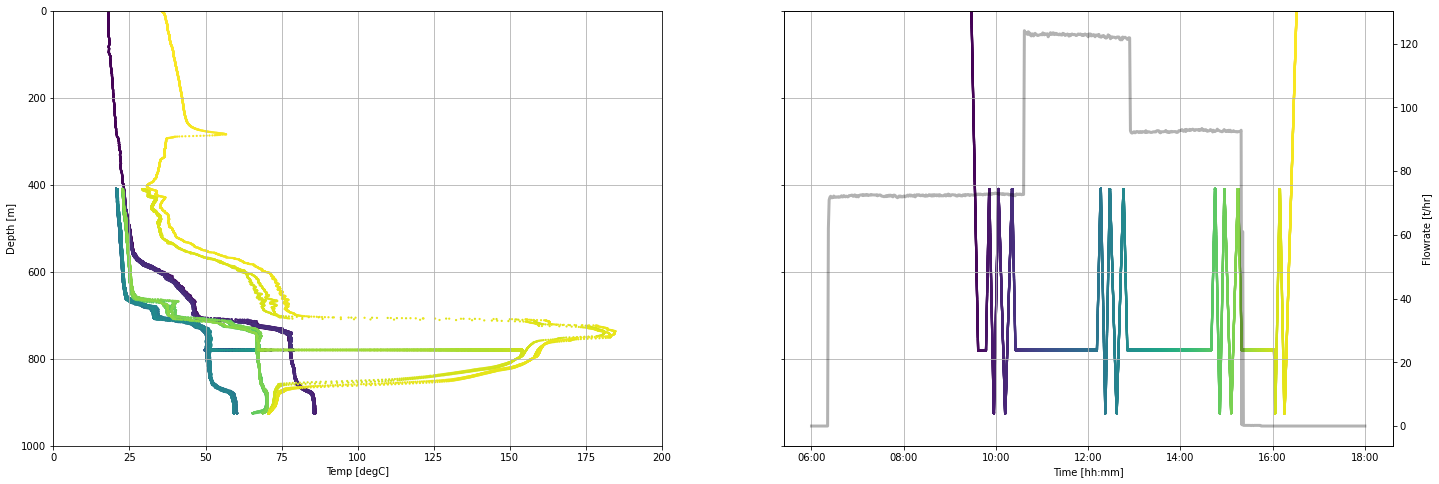

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(24,8),sharey=True)

spinner_scatter = ax1.scatter(pts.temp_degC, pts.depth_m, c = pts.timedelta_sec, s = 5, linewidths = 0)
datetime_scatter = ax2.scatter(pts.datetime, pts.depth_m, c = pts.timedelta_sec, s = 5, linewidths = 0)

ax3 = ax2.twinx()
ax3.plot(flowrate.datetime, flowrate.flow_tph, 
    c='k', linestyle = '-', linewidth = 3, alpha = 0.3, 
    label='Surface pump flowrate')

ax1.set_ylabel('Depth [m]')
ax1.set_xlabel('Temp [degC]')

ax2.set_xlabel('Time [hh:mm]')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax3.set_ylabel('Flowrate [t/hr]')

ax1.set_ylim(1000,0)
ax1.set_xlim(0,200)

for ax in [ax1, ax2]:
    ax.grid()


In [8]:
moving_pts = pts[
    (pts.speed_mps > 0.9 ) & (pts.speed_mps < pts.speed_mps.max()) | 
    (pts.speed_mps > pts.speed_mps.min() ) & (pts.speed_mps < -0.9)
    ]

In [9]:
moving_pts.describe()

,depth_m,speed_mps,cweight_kg,whp_barg,temp_degC,pressure_bara,frequency_hz,timedelta_sec
count,35728.000000,35728.000000,35728.000000,35728.000000,35728.000000,35728.000000,33812.000000,35728.000000
mean,619.309961,0.000889,121.474578,-0.555699,47.128879,23.426249,4.011365,13160.262688
std,184.603047,1.270866,26.823424,0.112767,30.663209,14.852001,13.698449,8729.420412
min,1.970752,-1.539693,25.393188,-0.616755,18.084463,0.059252,-29.385933,85.536000
25%,500.489075,-1.015137,106.350523,-0.612977,24.070804,10.544652,-9.005808,3027.240000
50%,629.704465,-0.979624,123.097855,-0.607455,37.806570,23.132948,9.903941,11724.480000
75%,758.224075,1.312978,139.718280,-0.605516,66.819466,35.503899,16.661721,20631.456000
max,925.073240,1.528768,193.862140,-0.264208,184.733380,51.779540,74.740814,25456.896000


In [10]:
min_timestamp = pts.timedelta_sec.iloc[0]
max_timestamp = pts.timedelta_sec.iloc[-1]

def subselect_plot(start_value, stop_value):
    f,ax = plt.subplots(1,1, figsize = (20,6))
    ax.scatter(moving_pts.timedelta_sec, moving_pts.depth_m,
        c = 'k', s = 1, linewidths = 0, label = 'Tool depth')
    ax1 = ax.twinx()
    ax1.plot(flowrate.timedelta_sec, flowrate.flow_tph, 
        ':', c='k', label='Surface pump flowrate')
    ymin = pts.depth_m.min()
    ymax = pts.depth_m.max() + 100
    ax.vlines(start_value, ymin, ymax, color='tab:green')
    ax.vlines(stop_value, ymin, ymax, color='tab:red')
    ax.set_ylim(pts.depth_m.max() + 100, 0)
    ax.set_xlabel('Timestamp [sec]')
    ax.set_ylabel('Tool depth [m]')
    ax1.set_ylabel('Flowrate [t/hr]')
    ax.set_xlabel('Time elapsed since the test started [sec]')
    ax.set_ylabel('Tool depth [m]')
    ax1.set_ylabel('Flowrate [t/hr]')

result = interactive(subselect_plot,
         
         start_value = FloatSlider
         (
             value = (max_timestamp - min_timestamp)/3 + min_timestamp,
             description = 'start',
             min = min_timestamp, 
             max = max_timestamp, 
             step = 10, 
             continuous_update=False,
             layout = Layout(width='80%'),
             ),
          
          stop_value = FloatSlider
          (
             value = (max_timestamp - min_timestamp)/2 + min_timestamp, 
             description = 'stop',
             min = min_timestamp, 
             max = max_timestamp, 
             step = 10, 
             continuous_update=False,
             layout = Layout(width='80%')
             )
)

display(result);


interactive(children=(FloatSlider(value=8515.296, continuous_update=False, description='start', layout=Layout(…

In [11]:
print(
    'start =',result.children[0].value,  
    '\nstop =', result.children[1].value,
    )

start = 8515.296 
stop = 12772.944


### Record your analysis

As part of making this process repeatable and so that it is easy to come back later to check the analysis, you need to use the range you have selected to manually define objects in the next step.

Copy-paste the timestamps printed above into the cell below. They are now the objects that define the start and stop points for splicing the moving_pts dataframe. 

We could have defined the start and stop objects as the result.children\[0\].value and result.children\[1\].value objects. But if we did this, you would lose your work because these ipywidget results change every time the sliders are moved or the notebook is re-run. 

In [12]:
# paste your values here
start = 24150.0 
stop = 24470.0

# create an informative title for the data
name = 'First heating run' 

pts_first_heating_run = moving_pts[
    (moving_pts.timedelta_sec > start) 
    & (moving_pts.timedelta_sec < stop)
]

flowrate_first_heating_run = flowrate[
    (flowrate.timedelta_sec > start) 
    & (flowrate.timedelta_sec < stop)
]

In [13]:
pts_first_heating_run.shape

(1216, 9)

The overview_fig function  generates a figure that displays our data selection. 

Note that surface flow rate = 0 because this log is acquired after the pumps were shut off. 

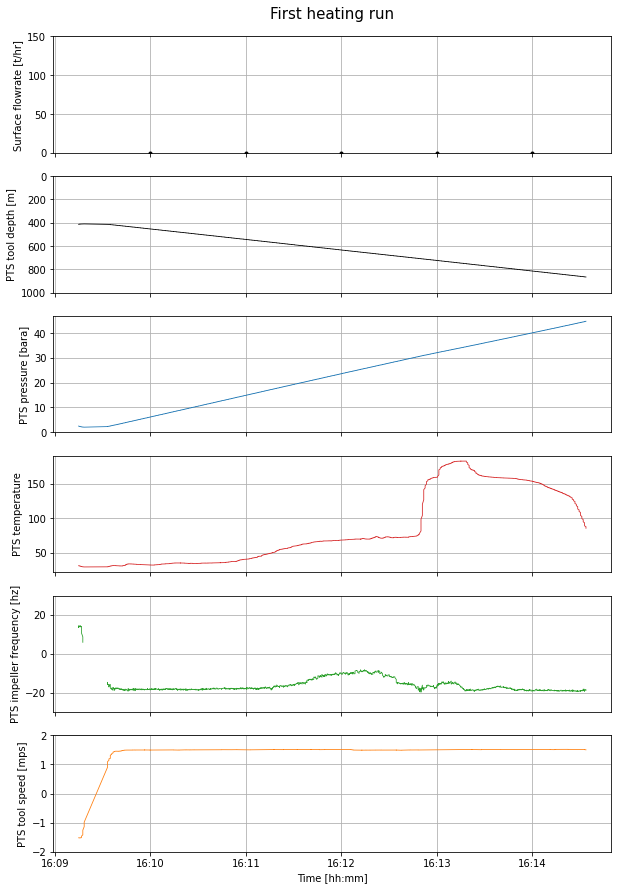

In [14]:
overview_fig(pts_first_heating_run, flowrate_first_heating_run, title = name).show()

In [15]:
pts_first_heating_run.to_csv('Data-Temp-Heating0days.csv', index=False)

In [16]:
 heating_37days = pd.read_csv('Data-Temp-Heating37days.csv')

In [17]:
# Convert bar gauge to bar atmosphere

heating_37days['pressure_bara'] = heating_37days.pres_barg - 1

heating_37days.head(2)

,depth_m,whp_barg,pres_barg,temp_degC,pressure_bara
0,0.0,4.019268,3.929268,10.48,2.929268
1,10.5,4.019268,3.929268,10.86,2.929268


In [18]:
# note that iapws uses SI units so some unit conversion is required

heating_37days['pressure_mpa'] = heating_37days.pressure_bara * 0.1  # convert pressure to MPa for ipaws

pressure = heating_37days['pressure_mpa'].tolist()
tsat = []
for p in pressure:
    saturation_temp = iapws.iapws97._TSat_P(p) - 273.15  # calculate saturation temp in Kelvin & convert to degC
    tsat.append(saturation_temp)
heating_37days['tsat_degC'] = tsat

heating_37days.head(2)

,depth_m,whp_barg,pres_barg,temp_degC,pressure_bara,pressure_mpa,tsat_degC
0,0.0,4.019268,3.929268,10.48,2.929268,0.292927,132.713496
1,10.5,4.019268,3.929268,10.86,2.929268,0.292927,132.713496


In [20]:
production_shoe = 462.5 # 13 3/8 production casing shoe in meters measured depth (mMD) from the casing head flange (CHF)
top_of_liner = 425 # top of perferated 10 3/4 liner in meters measured depth (mMD) from CHF
terminal_depth = 946 # deepest drilled depth 
# the perferated liner is squatted on bottom but didn't quite make it all the way down (bottom of liner is 931 mMD)

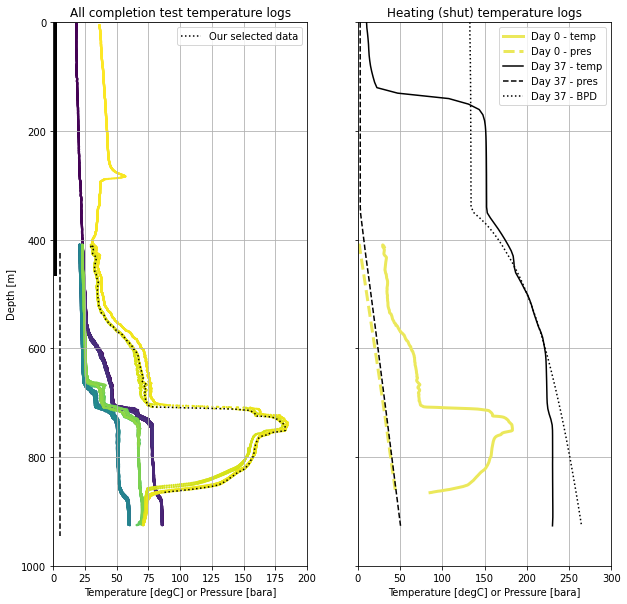

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,10),sharey=True)


ax1.set_title('All completion test temperature logs')

# all temp data colored by time 
ax1.scatter(moving_pts.temp_degC, moving_pts.depth_m,     
    c = moving_pts.timedelta_sec, s = 5, linewidths = 0)

# our sub-selected data
ax1.plot(pts_first_heating_run.temp_degC, pts_first_heating_run.depth_m,
    color = 'k', linestyle = ':', label = 'Our selected data')

# blank well casing
ax1.plot([1, 1],[0, production_shoe],
    color = 'k', linewidth = 3, linestyle = '-')

# perforated well casing
ax1.plot([5, 5],[top_of_liner, terminal_depth],     
    color = 'k', linewidth = 1.5, linestyle = '--')


ax2.set_title('Heating (shut) temperature logs')

# our sub-selected pressure + temp data
ax2.plot(pts_first_heating_run.temp_degC, pts_first_heating_run.depth_m, 
    color ='#EBE85B', linewidth = 3, label = 'Day 0 - temp')

ax2.plot(pts_first_heating_run.pressure_bara, pts_first_heating_run.depth_m, 
    linestyle = '--', linewidth = 3, color = '#EBE85B', label = 'Day 0 - pres')

# stable pressure + temp data
ax2.plot(heating_37days.temp_degC, heating_37days.depth_m, 
    color = 'k', label = 'Day 37 - temp')

ax2.plot(heating_37days.pressure_bara, heating_37days.depth_m, 
    linestyle = '--', color = 'k', label = 'Day 37 - pres')

# saturation temp for the stable pressure
ax2.plot(heating_37days.tsat_degC, heating_37days.depth_m, 
    linestyle = ':', color = 'k', label = 'Day 37 - BPD')


ax1.set_ylim(1000,0) 
ax1.set_ylabel('Depth [m]')
ax1.set_xlim(0,200)
ax1.legend()

ax2.legend()
ax2.set_xlim(0,300)

for ax in [ax1,ax2]:
    ax.set_xlabel('Temperature [degC] or Pressure [bara]')
    ax.grid()
